In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

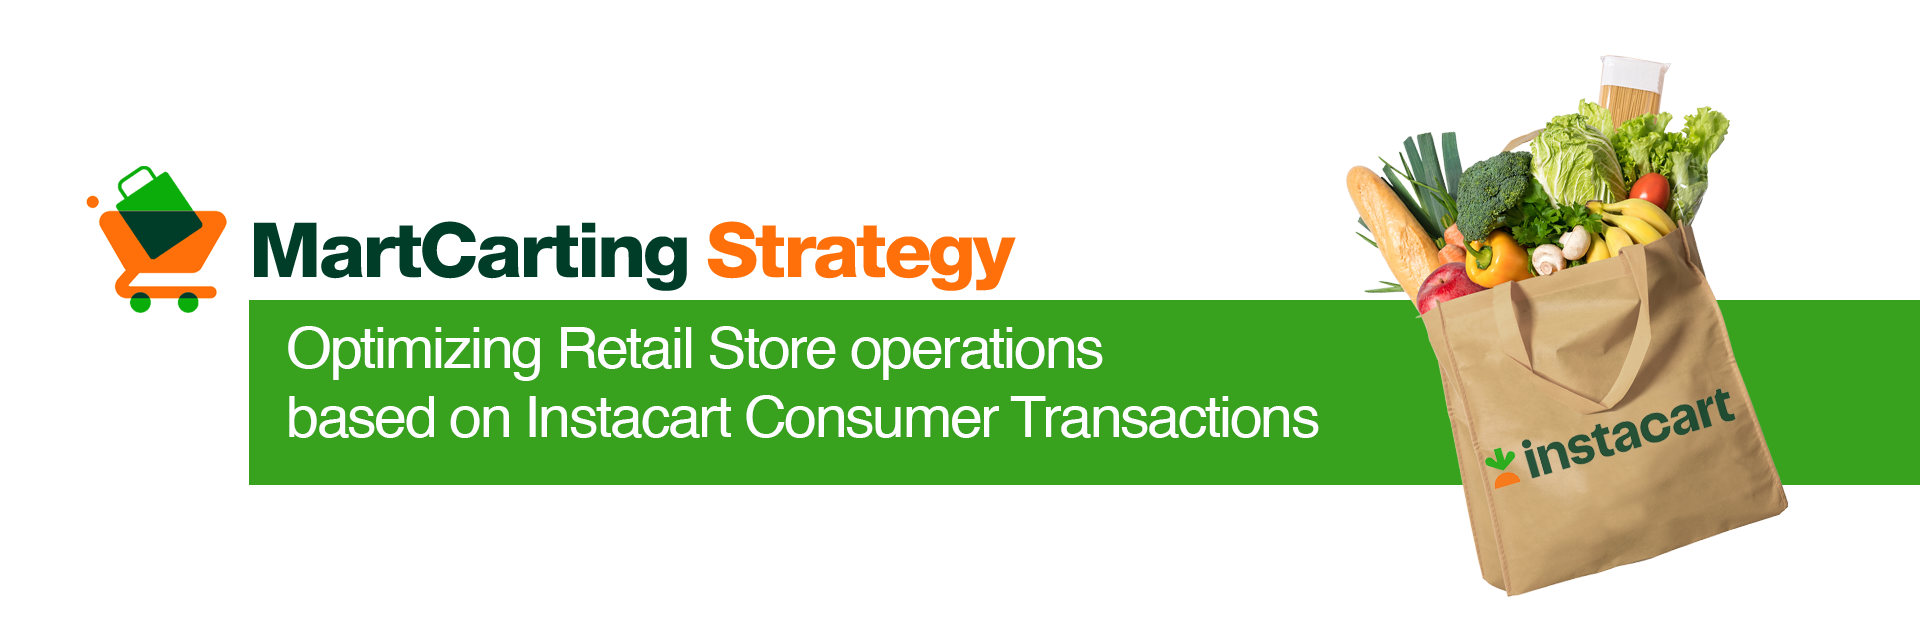

<a id='ExecSum'></a>
<h1 style="color:#003d2a; background-color:#deedd6; border: 1px solid #ffffff; padding: 10px 0;">EXECUTIVE SUMMARY</h1>

This study aimed to identify insights and provide operational recommendations for grocery or retail businesses by analyzing transactional data from Instacart, an online grocery store. The dataset contained 3.4 million orders of 49,685 products across 21 departments over the course of a year. 

To answer the question ***How can businesses leverage frequent itemset mining (FIM) in the Instacart dataset to enhance cross-selling and identify new business opportunities?***, the team employed a methodology focusing on **exploratory data analysis (EDA) and FIM**. In the EDA phase, the team analyzed the sales quantity, product count, and department count by product to identify trends and patterns in customer behavior. In the FIM phase, the team used the **FP-Growth algorithm** to identify frequently co-occurring products and generate association rules, and used these rules to create product bundles. 

Further by performing **EDA**, the team identified the top-selling products and departments, the average number of products per order, and the most common order size. This analysis revealed that fresh produce, dairy, and snack items were highly valued by customers, and that the average number of products sold per order was 10.

To identify cross-selling opportunities, the team used an FIM technique called **FP-Growth algorithm** to identify frequently co-occurring products and department product bundles. Based on a set minimum support and confidence, the FIM results were used to generate two recommendation types: **optimize placement** and **discounted bundling**.

**Optimize placement** refers to the strategy of placing frequently co-occurring products within the **same department** in **close proximity to each other in physical stores or online platforms**. 

**Discounted bundling** is a strategy that involves offering customers discounts when they purchase a bundle of frequently co-occurring products from **different departments**. This approach incentivizes customers to buy multiple products at once which can lead to an increase in the average order value.


The team recommends for businesses to leverage bundled products from different departments, specialize in offering fresh produce, dairy products, and unique snack items, and optimize their order fulfillment and inventory management processes through targeted promotions.

Future work for improving the FIM includes utilizing weighted FIM, using more advanced analytics techniques such as deep learning and natural language processing, and leveraging the predictive power of the FIM to forecast future behavior.

Lastly, some assumptions and limitations of the study include not considering the amount or volume of the item bought per transaction, not considering single-item transactions, and assuming the Apriori principle holds. It's also important to note that this is not a recommender tool and user preferences were not included in the study, although it can be valuable in developing a robust recommender system.

In conclusion, FIM can provide valuable insights to optimize operations and drive sales for businesses, but its limitations and potential for future improvements should always be considered.

<a id='TContents'></a>
<h1 style="color:#003d2a; background-color:#deedd6; border: 1px solid #ffffff; padding: 10px 0;">TABLE OF CONTENTS</h1>

[IMPORT LIBRARIES AND DEFINE FUNCTIONS](#Libraries) <br> 
[EXECUTIVE SUMMARY](#ExecSum) <br> 
[LIST OF TABLES AND FIGURES](#Tables) <br> 
[I. PROBLEM STATEMENT](#Problem) <br> 
[II. MOTIVATION](#Motivation) <br> 
[III. METHODOLOGY](#Methodology) <br> 
[IV. DATA COLLECTION AND PREPROCESSING](#Collection) <br> 
[V. DATA EXPLORATION](#Exploration) <br> 
[VI. RESULTS AND DISCUSSION](#Results) <br>
- [Frequent Itemset Mining](#FIM) <br>
- [Interpretation of FIM Results](#FIM_Results) <br>

[VII. CONCLUSION](#Conclusion) <br> 
[VIII. RECOMMENDATION](#Recommendation) <br> 

- [Limitations of the Study](#Limitations)
- [Recommendation](#Recommendation2)
- [Future Work](#FutureWork) <br> 

[REFERENCES](#References) <br> 

<a id='Libraries'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">IMPORT LIBRARIES AND DEFINE FUNCTIONS</h1>

This section involves importing the necessary libraries and defining the required functions, including global libraries, helper functions, and Frequent Itemset Mining functions. This step lays the foundation for the subsequent analysis steps.

<h2 style="color:#003d2a; font-size:26px;">A. Global Libraries & Functions</h2> 

This step involves importing global libraries and defining global helper functions that will be used throughout this report.

<h3 style="color:#ff700a; font-size:24px">A1. Global Libraries</h3>

In [4]:
# Libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import re
import time
import os
import joblib
import fim
from PIL import Image
import pickle
from urllib.parse import urljoin
from tqdm.notebook import tqdm, trange
import warnings
from itertools import combinations
from tqdm.notebook import trange, tqdm
from IPython.display import HTML
from sklearn.exceptions import ConvergenceWarning
from IPython.display import display, display_html

# Global settings
%matplotlib inline

# Pandas settings
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

# Error Filters
warnings.filterwarnings("ignore")

# Global variables
c_orange = '#ff700a'
c_dgreen = '#003d2a'
c_green = '#0aad0a'
c_lgreen = '#deedd6'
colors = plt.get_cmap('Greens')(np.linspace(0.15, 0.60, 10))

<h3 style="color:#ff700a; font-size:24px"> A2. Global Helper Functions</h3>

In [5]:
# Global Helper Functions
def save_pkl(obj, name, prompt=False):
    """Save an object to a pickle file.
    """
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)

    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)

    if prompt:
        print('Object pickled for future use.')

    return


def load_pkl(name, prompt=False):
    """Load an object from a pickle file.
    """
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")

    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    pkl = joblib.load(fp)

    if prompt:
        print('Pickle file loaded.')

    return pkl


def get_all_files():
    """Returns a dictionary of all the csv files in a given path.
    """
    # loading data from mnt
    try:
        with open('dfs.pkl', 'rb') as f:
            dfs = pickle.load(f)

    except Exception:
        path = '/mnt/data/public/instacart/instacart_2017_05_01/'
        files = ['aisles', 'departments', 'order_products__prior',
                 'order_products__train', 'orders', 'products']
        dfs = {}

        for file in tqdm(files):
            adr = path+file+'.csv'
            dfs[file] = pd.read_csv(adr, index_col=0)

        with open('dfs.pkl', 'wb') as f:
            pickle.dump(dfs, f)
    return dfs


def get_combined_df():
    """Returns the combined dataframe of all the relevant files in 
    the Instacart dataset.
    """
    df_orders = dfs['orders'].reset_index()[['order_id', 'user_id']]
    df_products = dfs['products'].reset_index()[['product_id', 'product_name',
                                                'department_id']]
    df_order_products = (pd.concat([dfs['order_products__prior'],
                                   dfs['order_products__train']],
                                   ignore_index=False)
                         .sort_index().reset_index()[['order_id', 'product_id']])
    df_departments = dfs['departments'].reset_index()[
        ['department_id', 'department']]

    df_combined = pd.merge(df_order_products, df_products,
                           on='product_id', how='left')
    df_combined2 = pd.merge(df_combined, df_departments,
                            on='department_id', how='left')
    df_all = pd.merge(df_combined2, df_orders, on='order_id', how='left')
    return df_all


def get_products():
    """Get dictionary of `product_id`s => `product_name`s
    """
    try:
        product_dict = load_pkl('product_dict')
    except:
        f_path = ('/mnt/data/public/instacart/instacart_2017_05_01/'
                  'products.csv')
        product_dict = (pd.read_csv(f_path)
                        .set_index('product_id')['product_name']
                        .to_dict())
        save_pkl(product_dict, 'product_dict')

    return product_dict


def get_details():
    """Get department details of products"""
    fpath_prod = ('/mnt/data/public/instacart/instacart_2017_05_01/'
                  'products.csv')
    df_prod = pd.read_csv(fpath_prod)

    fpath_dept = ('/mnt/data/public/instacart/instacart_2017_05_01/'
                  'departments.csv')
    df_dept = pd.read_csv(fpath_dept)

    df_details = pd.merge(df_prod,
                          df_dept,
                          how='left',
                          left_on='department_id',
                          right_on='department_id')[['product_name',
                                                     'department']]

    return df_details


def preview_df(df, display_df=True):
    """Displays the number of data points, nulls, statistics, and preview
    of the dataframe."""
    display_html(f'<b>Number of Data Points:</b> {df.shape[0]}',
                 raw=True)
    display_html(f'<b>Number of Features:</b> {df.shape[1]}',
                 raw=True)
    display_html(f'<b>Number of Nulls:</b> {df.isna().any(axis=1).sum()}',
                 raw=True)
    if display_df:
        # Display first 3 rows of the df
        print(f'First three rows of the df:\n')
        display(df.head(3))
        # Get summary statistics for the numerical columns and transpose the DataFrame
        # for more readable output
        print(f'\nSummary statistics for numerical columns:\n')
        display(df.describe())
    else:
        print('Count of missing values:')
        display(df.isna().sum())


def center_fig(fig, name, width=80):
    """Saves the current figure into an image and center-display
    """
    # Save the plot as a PNG file
    folder = 'figures'
    ext = '.png'
    if not os.path.exists(folder):
        os.makedirs(folder)

    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)

    fig.savefig(fp)  # Create an HTML img tag to display the image
    # Display the img tag in the Jupyter Notebook
    img_tag = (f'<img src="{fp}" alt="{name}"'
               'style="display:block; margin-left:auto;'
               f'margin-right:auto;width:{width}%;">')
    display(HTML(img_tag))
    plt.close(fig)


def plot_top_products(df):
    """Plots the top 10 products in the dataset.
    """
    # Group by product_id and count the number of occurences
    top_products = (df.groupby('product_name')['product_id']
                    .count()
                    .reset_index())
    top_products = top_products.rename(columns={'product_id': 'Count'})
    top_products = (top_products.sort_values(by='Count', ascending=False)
                    .head(10).sort_values(by='Count'))

    # Plot the top products using a bar chart
    fig, ax = plt.subplots(figsize=(12, 8))  # Add figsize parameter
    top_products.plot(kind='barh', x='product_name', y='Count',
                      color=colors, legend=False, ax=ax)
    ax.set_title('10 Best Selling Products',
                 fontsize=24, c=c_dgreen, weight='bold')
    ax.set_xlabel('Count', fontsize=16, c=c_dgreen, weight='bold')
    ax.set_ylabel('Products', fontsize=16, c=c_dgreen, weight='bold')
    plt.show()


def plot_products_by_dept(df):
    """Plots the count of products sold by department.
    """
    # Group by department_id and count the number of occurences
    count_per_dept = df_all.groupby(
        'department')['department_id'].count().reset_index()
    count_per_dept = count_per_dept.rename(columns={'department_id': 'Count'})
    count_per_dept = count_per_dept.sort_values(by='Count')

    # Plot the products sold using a bar chart
    fig, ax = plt.subplots(figsize=(12.5, 8))  # Add figsize parameter
    count_per_dept.plot(kind='barh', x='department', y='Count',
                        color=c_green, alpha=0.5, legend=False, ax=ax)
    ax.set_title('Count of Products Sold by Department', fontsize=24,
                 c=c_dgreen, weight='bold')
    ax.set_xlabel('Count [in 10 millions]', fontsize=16,
                  c=c_dgreen, weight='bold')
    ax.set_ylabel('Products', fontsize=16, c=c_dgreen, weight='bold')
    plt.show()


def products_per_order(df):
    """Plots the number of products sold by department and prints the 
    average number of products sold in 2017.
    """
    # Get the number of products per order
    products_per_order = df['order_id'].value_counts()
    print(f'Average number of products sold per order:'
          f'   {products_per_order.mean():.0f} products\n\n'
          f'Minimum number of products per order:'
          f'   {products_per_order.min():.0f} product\n\n'
          f'Maximum number of products per order:'
          f'   {products_per_order.max():.0f} products\n\n'
          f'Total number of orders:'
          f'   {df.order_id.nunique():,.0f} orders\n\n'
          f'Total number of products sold:'
          f'   {df.product_id.nunique():,.0f} products\n\n')

    # Plot histogram of the number of products per order
    fig, ax = plt.subplots(figsize=(12.5, 8))  # Add figsize parameter
    products_per_order.plot(kind='hist', bins=50, color=c_green, alpha=0.5,
                            legend=False, ax=ax)
    ax.set_title('Histogram of Products Sold by Order', fontsize=24,
                 c=c_dgreen, weight='bold')
    ax.set_xlabel('Number of Products', fontsize=16, c=c_dgreen, weight='bold')
    ax.set_ylabel('Count', fontsize=16, c=c_dgreen, weight='bold')
    plt.xlim(0, 55)
    plt.show()


def plot_sales_quantity_by_product():
    """Plots the sales quantity by product, prints the % of products
    with more than 1000 sales quantity and the total number of products sold.
    """

    # create dataframe
    try:
        with open('df.pkl', 'rb') as f:
            df = pickle.load(f)
    except Exception:
        combined = pd.concat([dfs['order_products__prior'],
                              dfs['order_products__train']],
                             ignore_index=False).sort_index()
        itemset = pd.DataFrame(combined.groupby(
            combined.index)['product_id'].agg(set))
        df = pd.merge(itemset, dfs['orders'],
                      left_index=True, right_index=True)
        with open('df.pkl', 'wb') as f:
            pickle.dump(df, f)

    data = list(df.product_id)

    # Create a dictionary of item frequencies
    item_counts = {}
    for transaction in data:
        for item in transaction:
            if item in item_counts:
                item_counts[item] += 1
            else:
                item_counts[item] = 1

    # Convert the dictionary into a pandas DataFrame
    itemset_freq = pd.DataFrame({'Item': list(item_counts.keys()),
                                 'Frequency': list(item_counts.values())})

    product_frequency = itemset_freq.sort_values(by='Frequency',
                                                 ascending=False)
    product_frequency.index = product_frequency.Item
    product_frequency.drop('Item', axis=1, inplace=True)

    # % of products that had more than 1000 quantity sold
    freq_pct = (product_frequency[product_frequency.Frequency > 1000]
                .count() / product_frequency.count())[0]
    print(f'% of products that with more than 1000 quantity sold: '
          f'{freq_pct:.2%}')
    print(f'Number of products sold in 2017: '
          f'{product_frequency.sum()[0]:,.0f}')

    # Plot
    fig, ax = plt.subplots(figsize=(12.5, 8))  # Add figsize parameter
    itemset_freq['Frequency'].plot(color=c_green, alpha=0.5,
                                   legend=False, ax=ax)
    ax.set_title('Sales Quantity by Product', fontsize=24,
                 c=c_dgreen, weight='bold')
    ax.set_xlabel('Product index', fontsize=16, c=c_dgreen, weight='bold')
    ax.set_ylabel('Count', fontsize=16, c=c_dgreen, weight='bold')
    plt.show()

<h2 style="color:#003d2a; font-size:26px;">B. FIM-based Functions</h2>

This step involves defining the following FIM-based functions that will be used for recommending retail operations improvements to businesses:

In [6]:
def get_transaction():
    """Get and create a transaction database from the given `df`
    """
    try:  # Ttry loading file
        df_db = load_pkl('df_db')
    except:
        df = load_pkl('df_all')
        df_db = df['product_id']
        df_db.name = 'transactions'

        # Get k-itemsets, k > 1
        mask_k = df_db.apply(lambda x: len(x)) > 1
        df_db = df_db[mask_k]

        # Save
        save_pkl(df_db, 'df_db')

    return df_db


def get_rules(df_db, supp, conf, k_range=2):
    """Get rules (inputs for the FIM-Based algorithm).
    """
    try:  # Try loading rules
        df_rules = load_pkl(f'df_rules_{supp}_{conf}_{k_range}')
    except:
        try:  # Try loading support values
            denom = load_pkl(f'denom_{supp}')
            num = load_pkl(f'num_{supp}_{k_range}')

        except:
            # Get support if 1-itemsets
            freq = fim.fpgrowth(
                df_db,
                target='s',
                zmin=1,
                zmax=1,
                supp=supp,
                report='a'
            )
            denom = {x[0][0]: x[1] for x in freq}
            save_pkl(denom, f'denom_{supp}')

            num = []
            for k in trange(2, k_range+1):
                # Try searching for frequent itemsets if successful earlier
                if len(freq) > 0:
                    freq = fim.fpgrowth(
                        df_db,
                        target='s',
                        zmin=k,
                        zmax=k,
                        supp=supp,
                        report='a'
                    )
                    num.extend(freq)
            # Save
            save_pkl(num, f'num_{supp}_{k_range}')

        # Get rules
        try:  # Try loading results
            results = load_pkl(f'results_{supp}_{conf}_{k_range}')
        except:
            results = []
            for itemset, value in tqdm(num):
                for item in itemset:
                    if value/denom[item] >= conf/100:
                        results.append({
                            'antecedent': set(itemset)-{item},
                            'consequent': item,
                            'confidence': value/denom[item]
                        })

            save_pkl(results, f'results_{supp}_{conf}_{k_range}')

        # Convert to table
        df_rules = pd.DataFrame().from_dict(results)
        df_rules['antecedent'] = (
            df_rules['antecedent'].apply(lambda x: ' '.join(map(str, x)))
        )
        df_rules = df_rules.pivot_table(index='antecedent',
                                        columns='consequent',
                                        values='confidence',
                                        fill_value=0)
        save_pkl(df_rules, f'df_rules_{supp}_{conf}_{k_range}')

    return df_rules


def get_bundles(df_rules, supp, thresh=50):
    """Get potential bundles based on FIM rules and item supports.
    """
    try:
        df_bundles = load_pkl(f'df_bundles_{thresh}')

    except:
        denom = load_pkl(f'denom_{supp}')
        low_sellers = [x[0]
                       for x
                       in sorted(denom.items(), key=lambda x: (x[1], x[0]))
                       if x[1] < thresh]

        # Get potential items for upselling
        potential = [x for x in low_sellers if x in df_rules.columns]

        # Get potential bundles
        mask = df_rules[potential].sum(axis=1) != 0

        bundles = (df_rules[mask]
                   .melt(ignore_index=False)
                   .reset_index())
        mask_bundle = bundles['value'] != 0
        df_bundles = bundles[mask_bundle].sort_values('value',
                                                      ascending=False)

        # Rename
        product_dict = get_products()
        df_bundles['antecedent'] = (
            df_bundles['antecedent'].astype('int').replace(product_dict)
        )
        df_bundles['consequent'].replace(product_dict, inplace=True)
        df_bundles.drop(columns=['value'], inplace=True)

        # Merge w/ other details
        df_details = get_details()

        df_bundles = (pd.merge(df_bundles,
                               df_details,
                               how='left',
                               left_on='antecedent',
                               right_on='product_name')
                      .drop(columns='product_name'))

        df_bundles = (pd.merge(df_bundles,
                               df_details,
                               how='left',
                               left_on='consequent',
                               right_on='product_name',
                               suffixes=['_antecedent', '_consequent'])
                      .drop(columns='product_name'))

        df_bundles['recommendation'] = np.where(
            df_bundles['department_antecedent'] ==
            df_bundles['department_consequent'],
            'optimize placement',
            'discounted bundling'
        )

        # Save
        save_pkl(df_bundles, f'df_bundles_{thresh}')

    return df_bundles

[Back to TOC](#TContents)

<a id='Tables'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">LIST OF TABLES AND FIGURES</h1>

The following tables and figures serve as reference for the subsequent steps in this report, providing summarized details about the data, methodology, and insights obtained.

<h2 style="color:#003d2a; font-size:26px;">TABLES</h2>

- Table 1. Methodology Details
- Table 2. Data Description of Features Used

<h2 style="color:#003d2a; font-size:26px;">FIGURES</h2>

- Figure 1. Methodology
- Figure 2. Plot: 10 Best Selling Products
- Figure 3. Plot: Count of Products Sold by Department
- Figure 4. Plot: Histogram of Products Sold by Order
- Figure 5. Plot: Sales Quantity by Product

[Back to TOC](#TContents)

<a id='Problem'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">I. PROBLEM STATEMENT</h1>

With the growing trend in online shopping, businesses in the grocery and retail industry are encountering greater obstacles when it comes to recommending relevant products, introducing new offerings to customers, and ultimately maximizing profits. Although online platforms like Instacart have access to a wealth of customer purchase history data, many businesses have yet to tap into its full potential.

To tackle this challenge, the team aims to provide a solution to the following problem statement:

***How can businesses leverage frequent itemset mining (FIM) in the Instacart dataset to enhance cross-selling and identify new business opportunities?***

[Back to TOC](#TContents)

<a id='Motivation'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">II. MOTIVATION</h1>

The success and competitiveness of businesses in the grocery and retail industry depend on their ability to introduce new offerings and implement optimal operational strategies. In today's online shopping landscape, customer purchase history data presents a valuable opportunity for businesses to uncover new opportunities and gain a competitive edge, while ensuring customer satisfaction. However, many businesses struggle to fully leverage this data to improve their operations.

To tackle these challenges, the team focused on utilizing FIM in the Instacart dataset to enhance cross-selling and identify new business opportunities. Through the use of the FP-Growth algorithm, the team will extract valuable insights by understanding customer buying patterns and trends, which can then be used to recommend operational strategies that can benefit any retail company. This analysis will enable businesses to uncover new opportunities, extract association rules between products, and make effective cross-selling decisions.

Leveraging customer data to improve operations is critical for long-term success in the grocery and retail industry. The team's approach to enhancing cross-selling and identifying new business opportunities through FIM in the Instacart dataset provides businesses with the necessary insights to optimize their operations, stay ahead of the competition, improve customer satisfaction, and increase sales revenue and profitability. This project aims to deliver significant improvements for businesses and create a more positive shopping experience for their customers.

[Back to TOC](#TContents)

<a id='Methodology'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">III. METHODOLOGY</h1>

As illustrated in ***Figure 1: Methodology***, the methodology section of this report consists of a **three-step** process, beginning with the collection and preprocessing of publicly available 2017 Instacart online grocery shopping dataset, followed by data exploration, and the determination and application of the most appropriate frequent itemset mining algorithm. 

Refer to ***Table 1: Methodology Details*** for more details about each step.

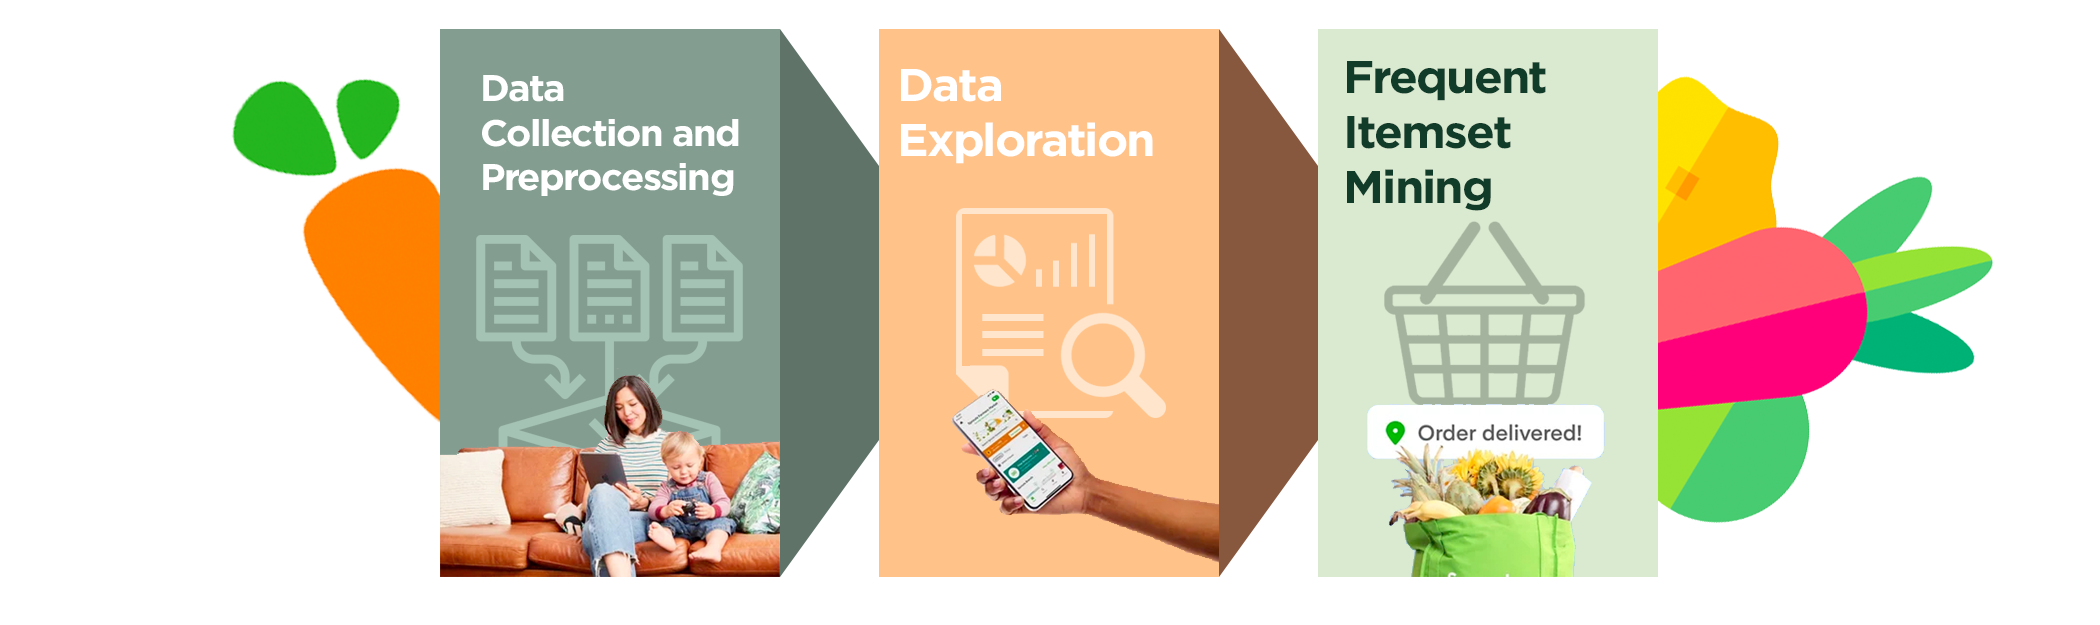

<center><span style="font-size:16px"><b>Figure 1. </b>Methodology</span></center>

<table >
    <tr style="color:#003d2a; background-color:#deedd6">
        <th style="text-align: left">NO.</th>
        <th style="text-align: left">STEP</th>
        <th style="text-align: left">DESCRIPTION</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">Data Collection and Preprocessing</td>
        <td style="text-align: left">Collect and preprocess 2017 Instacart online grocery shopping dataset.</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">Data Exploration</td>
        <td style="text-align: left">Perform EDA to explore and understand the relationships between the features, identify any trends/patterns, and provide insights regarding the Instacart dataset.</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">Frequent Itemset Mining</td>
        <td style="text-align: left">Since the number of both unique products and users are significantly large, the team will use FP-Growth algorithm and extract association rules between items to identify new business opportunities based on the rules, and use it to provide recommendations to any grocery or retail businesses.</td>
    </tr>
</table>

<center><span style="font-size:16px"><b>Table 1. </b>Methodology Details</span></center>

[Back to TOC](#TContents)

<a id='Collection'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">IV. DATA COLLECTION AND PREPROCESSING</h1>

The data collection and preprocessing section involves three key steps:
1. Identifying the data source;
1. Describing the data; and
1. Preprocessing and cleaning the data

<h2 style="color:#003d2a; font-size:26px;">A. Data Source</h2>

The team used five files from the Instacart dataset made available to the team via the jojie-collected public datasets (directory: `/mnt/data/public/instacart/instacart_2017_05_01/`) of the Asian Institute of Management (AIM).

The team chose and combined the following datasets[[1]](#Dataset) containing order and product-related features:

1. **Products** (directory: `/mnt/data/public/instacart/instacart_2017_05_01/products.csv`)
1. **Departments** (directory: `/mnt/data/public/instacart/instacart_2017_05_01/departments.csv`)
1. **Orders** (directory: `/mnt/data/public/instacart/instacart_2017_05_01/orders.csv`)
1. **Order Products-Prior** (directory: `/mnt/data/public/instacart/instacart_2017_05_01/order_products__prior.csv`)
1. **Order Products-Train** (directory: `/mnt/data/public/instacart/instacart_2017_05_01/order_products__train.csv`)

Both the `Order products-prior` and `Order products-train` have the same set of features so the team combined it to arrive at the full list of orders and products to consider in this report. `Prior` in this context means orders prior to that users' most recent order while `Train` is just the train data used to separate the dataset for machine learning (ML) model purposes. Since the team will not use the dataset for ML purposes, both `Order products-prior` and `Order products-train` were combined.

The dataset is stored in a Comma-Separated Values file format. After collecting and preprocessing the data, the team was able to gather and use 33,819,106 transactions (rows) and six features.

<h2 style="color:#003d2a; font-size:26px;">B. Data Description</h2>

The following features[[2]](#DataDict) were used and considered relevant for this report:

<table >
    <tr style="color:#003d2a; background-color:#deedd6">
        <th style="text-align: left">FEATURE NAME</th>
        <th style="text-align: left">FEATURE DESCRIPTION</th>
        <th style="text-align: left">DATA TYPE</th>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">order_id</td>
        <td style="text-align: left">Order identifier</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">product_id</td>
        <td style="text-align: left">Product identifier</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">user_id</td>
        <td style="text-align: left">Customer identifier</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">product_name</td>
        <td style="text-align: left">Name of the product</td>
        <td style="text-align: left">text</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">department_id</td>
        <td style="text-align: left">Deparment identifier</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#003d2a;">deparment</td>
        <td style="text-align: left">Name of the department</td>
        <td style="text-align: left">text</td>
    </tr>
</table>

<center><span style="font-size:16px"><b>Table 2. </b>Data Description of Features Used</span></center>

<h2 style="color:#003d2a; font-size:26px;">C. Data Collection and Preprocessing</h2>

<h3 style="color:#ff700a; font-size:24px">C1. Data Collection</h3>

To start processing the dataset, the team executed the following codes based on the directories and files mentioned in the Data Collection and Preprocessing Step in ***Section IV: Data Collection and Preprocessing*** of this report:


```Python

# Get all the csv files from the Instacart folder and save it to dfs as a dictionary 
dfs = get_all_files()

# Get the five relevant files mentioned in Data Source step and save it to a variable as a dataframe. 
df_all = get_combined_df()
```

In [7]:
# Get all the csv files from the Instacart folder and save it as a dictionary
dfs = get_all_files()

In [8]:
# Out of all the files in the dfs, use only the five files 
df_all = get_combined_df()

<h3 style="color:#ff700a; font-size:24px">C2. Data Preprocessing</h3>

<h4 style="color:#003d2a; font-size:20px">C2.1 Identify and Treat Missing Values</h4>

In [9]:
print(f'Count of missing values:')
display(df_all.isna().sum())

Count of missing values:


order_id         0
product_id       0
product_name     0
department_id    0
department       0
user_id          0
dtype: int64

The merged dataframe has no missing values.

<h4 style="color:#003d2a; font-size:20px">C2.2 Count and Display Unique Values per Feature</h4>

In [10]:
df_all.nunique()

order_id         3346083
product_id         49685
product_name       49685
department_id         21
department            21
user_id           206209
dtype: int64

Based on the count of unique values in the combined data, we can infer the following:
- The data includes 3,346,083 unique order IDs with 206,209 unique users which indicate that there were large reorders performed by such users.
- There are 49,685 unique product IDs indicating that there are large selections of distinct products that users order and reorder via Instacart. 
- Likewise, the result indicates that there are 21 departments in the Instacart dataset.

This dataframe will serve as a foundation for the succeeding data exploration and analysis that the team will perform.

<h4 style="color:#003d2a; font-size:20px">C2.3 Display Samples of the Clean and Preprocessed Dataset</h4>

In [11]:
df_all.sample(3)

,order_id,product_id,product_name,department_id,department,user_id
27088712,2739769,18583,Taboule Salad,20,deli,164915
12213416,1236231,47427,Chicken & Vegetable Potstickers With Sauce,1,frozen,205732
12803654,1295757,2237,Homemade Salted Butter,16,dairy eggs,197931


[Back to TOC](#TContents)

<a id='Exploration'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">V. DATA EXPLORATION</h1>

This section involves using the preprocessed and cleaned dataset in performing exploratory data analysis (EDA) to understand the relationships between the features, identify trends and patterns, and gain insights from the dataset.

<h2 style="color:#003d2a; font-size:26px;">A. Exploratory Data Analysis (EDA)</h2>

To perform the EDA, the team used preprocessed and cleaned dataset to obtain a broad overview of the dataset:

<h3 style="color:#ff700a; font-size:24px">A1. Display data types and statistics</h3>

The updated statistics and description of the data are now as follows:

In [12]:
preview_df(df_all)

Number of Data Points: 33819106

Number of Features: 6

Number of Nulls: 0

First three rows of the df:



,order_id,product_id,product_name,department_id,department,user_id
0,1,49302,Bulgarian Yogurt,16,dairy eggs,112108
1,1,10246,Organic Celery Hearts,4,produce,112108
2,1,49683,Cucumber Kirby,4,produce,112108



Summary statistics for numerical columns:



,order_id,product_id,department_id,user_id
count,33819106,33819106,33819106,33819106
mean,1710566,25576,10,102944
std,987401,14098,6,59467
min,1,1,1,1
25%,855413,13519,4,51435
50%,1710660,25256,9,102626
75%,2565587,37935,16,154412
max,3421083,49688,21,206209


<h3 style="color:#ff700a; font-size:24px">A2. Plots</h3>

<h4 style="color:#003d2a; font-size:20px">A2.1 Best Selling Products</h4>

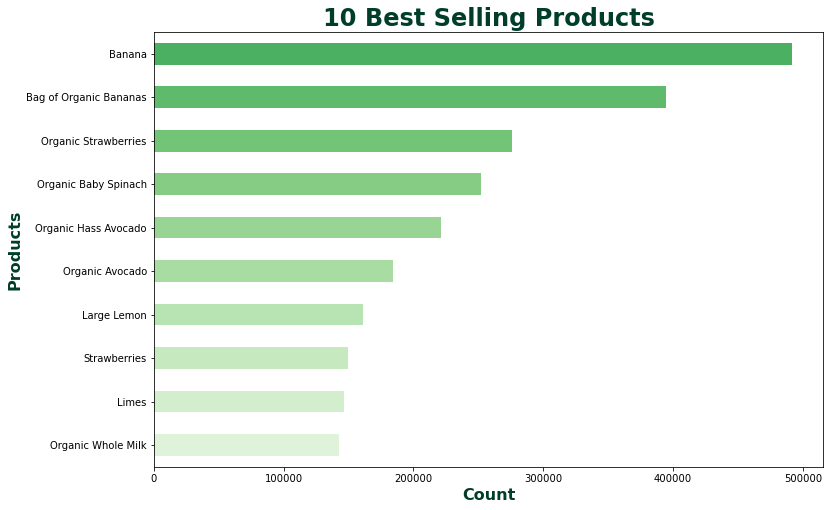

In [13]:
plot_top_products(df_all)

<center><span style="font-size:16px"><b>Figure 2. </b>Plot: 10 Best Selling Products</span></center>

**Insights**:

Based on ***Figure 2. Plot: Top 10 Products***, the team was able to visualize the frequency with which the top 10 products were ordered in the Instacart dataset. As such, the following can be inferred:

- The plot indicates that customers prefer fresh and organic fruits, vegetables, and dairy products.
- The top two most frequently ordered product are both kinds of bananas. 
- The customers are highly interested in buying organic and fresh produce items, such as strawberries, baby spinach, and avocado.
- Lemon and limes are also popular.
- The presence of "Bag of organic bananas" suggests that customers might be interested in buying organic fruits in bulk.
- Finally, the presence of "organic whole milk" indicate that customers are interested in buying organic dairy products.

<h4 style="color:#003d2a; font-size:20px">A2.2 Products Sold by Department</h4>

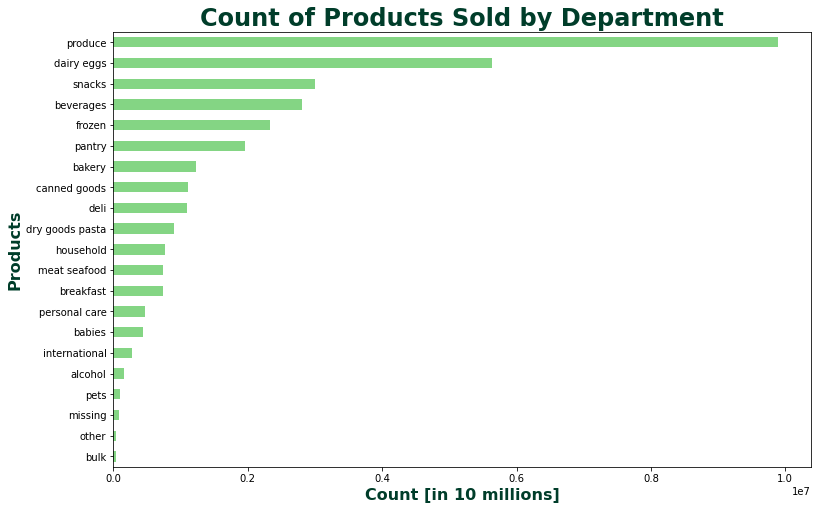

In [14]:
plot_products_by_dept(df_all)

<center><span style="font-size:16px"><b>Figure 3. </b>Plot: Count of Products Sold by Department</span></center>

**Insights**:

Based on ***Figure 3. Plot: Count of Products Sold by Department***, the team was able to visualize the count of products sold by department. As such, the following can be inferred:

- The top two departments in terms of product count are `produce` and `dairy eggs` which makes sense because the products in these departments are considered essential food items that are commonly purchased by customers during routine grocery shopping. The high count of products in `produce` department suggests that fresh fruits and vegetables are highly valued by customers and businesses that focus on providing a wide range of fresh produce can potentially increase their sales and customer satisfaction by making sure that these products do not go out of stock. This is consistent with the result of top 10 products with fresh produce such as fruits are popular and mostly ordered by customers. 
- On the other hand, the department with the smallest count of products is bulk, indicating that customers may not place a high priority on purchasing items in bulk. Businesses can potentially develop further strategies to increase sales of bulk products by offering promotions and discounts to incentivize customers to buy in larger quantities.
- `missing` department is ambiguous and may require further investigation if this pertains to real missing products caused by theft or not since this has a higher count than `other` and `bulk`. 
- Lastly, the other remaining notable takeaway from the plot is that the `international` department also has a moderate count of products sold indicating that customers are interested in diverse and unique food items from different regions in the world. Increasing the selection of products in this niche department can also drive sales and attract a larger customer base.

<h4 style="color:#003d2a; font-size:20px">A2.3 Products Sold per Order</h4>

Average number of products sold per order:   10 products

Minimum number of products per order:   1 product

Maximum number of products per order:   145 products

Total number of orders:   3,346,083 orders

Total number of products sold:   49,685 products




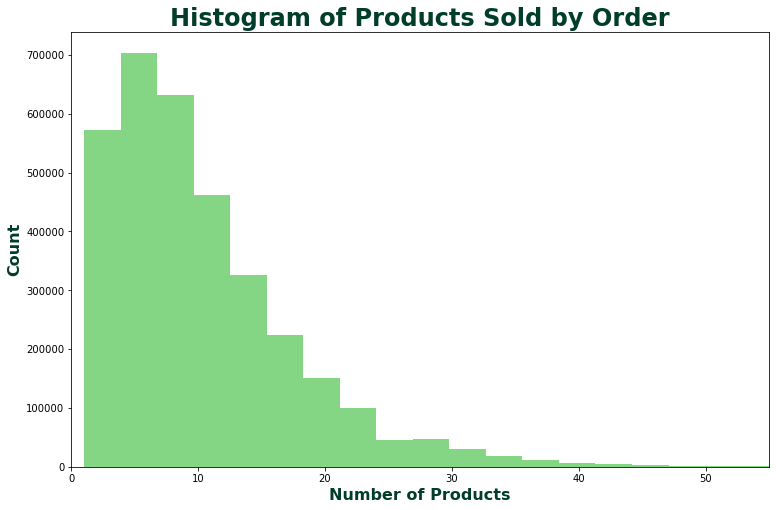

In [15]:
products_per_order(df_all)

<center><span style="font-size:16px"><b>Figure 4. </b>Plot: Histogram of Products Sold by Order</span></center>

**Insights**:

Based on ***Figure 4. Plot: Histogram of Products Sold by Order***, the team was able to visualize the count of products sold by order. As such, the following can be inferred:

- Minimum and maximum number of products sold per order are one and 145, respectively. This may present an opportunity for any business to encourage customers to add additional items for customers with order size of one or provide bulk discounts for customers who make very large purchases.
- Knowing total number of products sold and total number of orders in 2017 provides information about the scale of the business that any business should combine with other inventory management-related information to optimize inventory, storage, and order management.

<h4 style="color:#003d2a; font-size:20px">A2.4 Sales Quantity by Product</h4>

% of products that with more than 1000 quantity sold: 10.54%
Number of products sold in 2017: 33,819,106


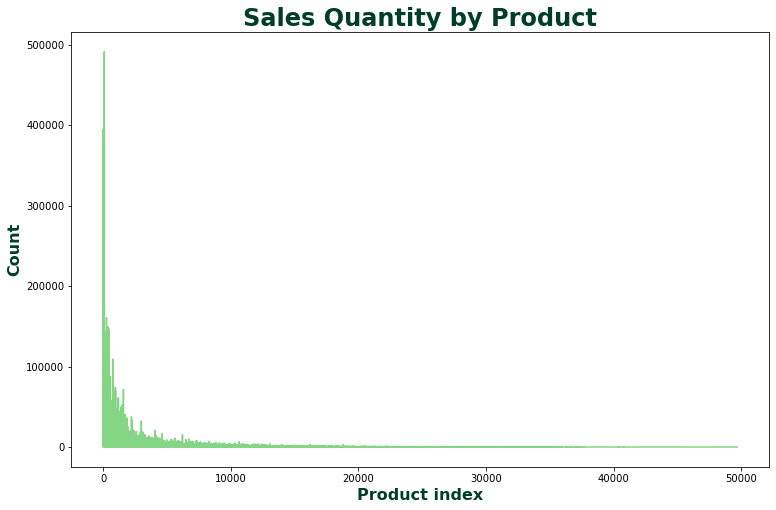

In [16]:
plot_sales_quantity_by_product()

<center><span style="font-size:16px"><b>Figure 5. </b>Plot: Sales Quantity by Product</span></center>

**Insights**:

Based on ***Figure 5. Plot: Sales Quantity by Product***, the team was able to visualize the sales quantity by product. As such, the following can be inferred:

- The fact that only 10.54% of products had more than 1000 quantity sold suggests that the majority of products sold were relatively low-volume items. 
- Businesses that encounter the same scenario can focus on identifying the reasons for the success of the top-selling products and try to replicate that success in other products. There could be a potential opportunity to increase the sales volume of products that had less than 1000 quantity sold by improving their marketing, pricing, or product positioning. Finally, analyzing the percentage of products with high sales volumes and the total number of products sold can help businesses identify areas for improvement and capitalize on their strengths to maximize profits.

[Back to TOC](#TContents)

<a id='Results'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">VI. RESULTS AND DISCUSSION</h1>

With a clear understanding of the characteristics and insights from the dataset, the team is now prepared to move on to the next phase.

<a id='FIM'></a>
<h2 style="color:#003d2a; font-size:26px;">A. Frequent Itemset Mining</h2>

This section entails utilizing FP-Growth algorithm and extracting association rules between items. By doing so, the team aims to uncover new business opportunities based on these rules and provide recommendations that can be utilized by any grocery or retail businesses.

In implementing FP-Growth algorithm, the team created and used the following functions:

* The **`get_transaction()`** function aims to create a transaction database from the given df. It performs the following steps: <br> 
    - First, it loads the complete dataset, `df_all`, using the load_pkl() function. <br> 
    - Next, it extracts the `product_id` column from `df_all` and renames it as transactions. <br> 
    - It then filters out all transactions with only one item (i.e., k-itemsets, where k = 1). <br> 
    - Finally, it saves the resulting transaction database, `df_db`, to a pickle file. <br> 


* The **`get_rules()`** function is used to generate association rules from the given transaction database (`df_db`) using the FP-Growth algorithm. The function takes three parameters: `supp` (support), `conf` (confidence), and `k_range` (the range of k-itemsets to consider). <br> 
    - The function generates the support values for 1-itemsets and stores them in a pickle file called `denom_{supp}`.  <br> 
    - It then generates the frequent itemsets for k > 1 and stores them in a list. <br> 
    - This list is then used to generate the association rules based on the confidence threshold, and the results are saved in a pickle file named `results_{supp}_{conf}_{k_range}`.  <br> 
    - The function then converts the results to a pandas dataframe, pivots it to make it easier to read and understand, and saves it to a pickle file called `df_rules_{supp}_{conf}_{k_range}`. <br> 


* Lastly, the **`get_bundles()`** function extracts potential bundles based on the FIM rules and item supports. 
    - The function first attempts to load the saved support values from the `denom_{supp}` pickle file.
    - Then it gets a list of items with low support count (< `thresh`) from the `denom` dictionary and stores the items in `low_sellers` list.
    - Next, it gets a list of potential items for upselling from the `df_rules` dataframe by selecting items that have a relationship with the items in low_sellers list.
    - Followed by, getting potential bundles by selecting rows from the `df_rules` dataframe that contain the potential items for upselling and melting the dataframe to create a long format. Rows with 0 value were removed and the dataframe was sorted in descending order of value.
    - Next, it replaces `product IDs` in `antecedent` and `consequent` columns with their corresponding `product names` using a dictionary obtained from the `get_products()` function and drops the value column.
    - The `df_bundles` dataframe was then merged with additional details from the `get_details()` function and the `product_name` column was dropped from both merge results. 
    - Further, a new recommendation column was added to indicate whether the bundle should be ***`optimized for placement`*** or ***`discounted`***. This is determined based on whether the antecedent and consequent items belong to the same department (optimize for placement or place in close proximity with each other within the same department) or not (provide discounts for the bundled products).
    - Finally, it saves the `df_bundles` dataframe to a pickle file named (`df_bundles_{thresh}`).

Based on the above discussion, the team then executed the following functions:

```Python
# Functions:

# Get the `df_db` or transactions database
get_transaction() 

# Use the `df_db` from the previous step to get the `df_rules` 
get_rules(df_db, supp, conf, k_range=2)

# Use the `df_rules` to get bundles
get_bundles(df_rules, supp, thresh=50)
```

For the purposes of this project, considering the memory constraints, the team used the following parameters. Note that these parameters can be changed depending on the business use case:

```Python
`supp=0.001`, `conf=50`, and `k_range=2`
```

The parameter `supp=0.001` is used to set the minimum support threshold for the frequent itemsets to 0.001. This means that an itemset must appear in at least 0.1% of the transactions to be considered frequent. The reason for choosing this threshold is based on the analysis of the sales quantity by product in ***Figure 5. Plot: Sales Quantity by Product***, which revealed that only 10.54% of the products had more than 1000 quantity sold. Therefore, in order to balance the need to offer a wide selection of products with the challenge of selling low-volume items, the team decided that a support of 0.001 would be an appropriate starting point for this report.


On the other hand, the team has set `conf=50` as the minimum confidence threshold for the association rules, which means that the conditional probability of an item B being purchased given that item A is purchased should be at least 50%. This decision was made based on the same rationale for support and the observation that the bulk items in this dataset appear to be underoptimized so there is an opportunity to replace or bundle the items offered in bulk with other items or provide discount for it.


The `k_range` parameter in the get_rules() function is used to specify the range of itemset sizes to be included in the association rule mining process. Specifically, `k_range=2` means that the algorithm will only consider frequent itemsets that contain 2 or fewer items. The reason for setting `k_range=2` is due to memory constraints. Association rule mining algorithms can require significant memory and processing power, especially when dealing with large datasets. Limiting the itemset size to 2 or fewer items helped to reduce the computational load and minimize the risk of kernel dying due to memory constraints. While setting k_range=2 may result in missing some potentially valuable association rules involving larger itemsets, it is a practical compromise to balance the need for comprehensive analysis with the resources available.

In [17]:
df_rules = get_rules(get_transaction(), 0.001, 50, k_range=2)
print(f'Executing get_rules(get_transaction(), 0.001, 50, k_range=2) '
      f'function:\nBased on the above set criteria, the shape of the rules '
      f'table is: {df_rules.shape}\n'
      f'The following also shows the first five rows of the rules table:')

df_rules.head()

Executing get_rules(get_transaction(), 0.001, 50, k_range=2) function:
Based on the above set criteria, the shape of the rules table is: (225, 246)
The following also shows the first five rows of the rules table:


consequent,172,426,658,677,1193,1328,1998,2142,2628,2657,...,48220,48407,48453,48507,48617,48711,48930,49105,49519,49570
antecedent,,,,,,,,,,,,,,,,,,,,,
10172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_bundles = get_bundles(df_rules, 0.001, thresh=70)
print(f'Executing get_bundles(df_rules, 0.001, thresh=70) '
      f'function:\nBased on the above set criteria, the shape of the '
      f'df_bundles table is: {df_bundles.shape}\n'
      f'The following also shows the sample five rows of the df_bundles table:')
df_bundles.sample(5)

Executing get_bundles(df_rules, 0.001, thresh=70) function:
Based on the above set criteria, the shape of the df_bundles table is: (115, 5)
The following also shows the sample five rows of the df_bundles table:


,antecedent,consequent,department_antecedent,department_consequent,recommendation
70,Crunchy Oats N' Honey Granola Bars,Gourmet French Roast Ground Coffee,snacks,beverages,discounted bundling
30,Beer,Hefeweizen Beer,alcohol,alcohol,optimize placement
34,Santa Fe Style Salad Cafe Bowl,Ham & Swiss Sandwich,produce,deli,discounted bundling
104,Banana,Graduates Grabbers Pear and Squash,produce,babies,discounted bundling
39,Banana,Ancient Grains Apricot Blended Low-Fat Greek Yogurt,produce,dairy eggs,discounted bundling


<a id='FIM_Results'></a>
<h2 style="color:#003d2a; font-size:26px;">B. Interpretation of FIM Results</h2>

The FP-Growth algorithm up to get_bundles() function implementation produced two recommendation types: **Optimize placement** and **Discounted bundling**.

<h3 style="color:#ff700a; font-size:24px">B1. Optimize Placement</h3>

**Optimize Placement or Optimize Product Placement** refers to the strategy of placing frequently co-occurring products in close proximity to each other in **physical stores or online platforms**. 

In this recommendation type, the team categorized frequently co-occurring products with resulting antecedent and consequent from the **same department** as best for optimizing product placement in **physical store or online platform**.

For example, place All-Purpose Unbleached Flour and Extra Virgin Olive Oil Spray (based on the df_bundles table) **in close proximity with each other** to increase the likelihood of customers buying both products.

In [19]:
optimize_placement = df_bundles[df_bundles.recommendation == 'optimize placement']
print(f'# of co-occuring products recommended for optimizing product '
      f'placement:{optimize_placement.shape}\n\n'
      f'Sample 5 rows in the optimize placement recommendation type:')

display(optimize_placement.sample(5))

# of co-occuring products recommended for optimizing product placement:(66, 5)

Sample 5 rows in the optimize placement recommendation type:


,antecedent,consequent,department_antecedent,department_consequent,recommendation
12,Organic Baby Food Fruit Mashup Green Kale & Apples 7+ Months,Organic Baby Food Fruit Mashup Mama Bear Blueberry 7+ Mo,babies,babies,optimize placement
91,"Organic Banana, Cinnamon & Granola Stage 2 Baby Food",Organic Apple Pumpkin & Granola Stage 2 Baby Food,babies,babies,optimize placement
31,Black Cherry Sparkling Water Beverage,Pineapple Coconut Sparkling Water,beverages,beverages,optimize placement
72,Crustless Chicken Pot Pie,Roasted Turkey With Garlic Mashed Cauliflower,frozen,frozen,optimize placement
62,Chardonnay,"Grape Wine, Delicious Red",alcohol,alcohol,optimize placement


<h3 style="color:#ff700a; font-size:24px">B2. Discounted Bundling</h3>

**Discounted bundling** recommendation type refers to **offering discounts to customers when they purchase a bundle of products.** This strategy can be done by **incentivizing customers** to purchase multiple products at once which can result to the increase in their average order value.

In this study, the team recommends to apply **discounted bundling** to co-occuring products with resulting antecedent and consequent from the **different department**. 

This recommendation type is effective for identifying **cross-selling strategies** and this can also be combined with strategies pertaining to optimizing department product includes in **bulk** department by offering a better set of bundles using FIM results based on a set support and confidence.

For example, **offer discounts to a bundled Crunchy Oats N' Honey Granola Bars and Gourmet French Roast Ground Coffee**	(based on the df_bundles table) to encourage customers to buy the bundled products.

In [20]:
discounted_bundling = df_bundles[df_bundles.recommendation == 'discounted bundling']
print(f'# of co-occuring products recommended for discounted bundling: '
      f'{discounted_bundling.shape}\n\n'
      f'Sample 5 rows in the discounted bundling recommendation type:')

display(discounted_bundling.sample(5))

# of co-occuring products recommended for discounted bundling: (49, 5)

Sample 5 rows in the discounted bundling recommendation type:


,antecedent,consequent,department_antecedent,department_consequent,recommendation
33,Banana,Ham & Swiss Sandwich,produce,deli,discounted bundling
32,Sparkling Natural Mineral Water,Bamba Peanut Snack With Hazelnut Filling,beverages,international,discounted bundling
86,Banana,Plain New York Bagels,produce,bakery,discounted bundling
15,Macaroni & Cheese,Vodka Vanilia,frozen,alcohol,discounted bundling
70,Crunchy Oats N' Honey Granola Bars,Gourmet French Roast Ground Coffee,snacks,beverages,discounted bundling


[Back to TOC](#TContents)

<a id='Conclusion'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">VII. CONCLUSION</h1>

Based on the **exploratory data analysis** and **frequent itemset mining** performed on the Instacart dataset, it can be concluded that customers have a preference for fresh and organic produce items such as bananas, strawberries, baby spinach, and avocado, as well as dairy products such as organic whole milk. The `produce` and `dairy/eggs` departments were found to have the highest product counts, indicating that businesses that focus on providing a wide range of fresh produce can potentially increase their sales and customer satisfaction. In addition, businesses can focus on identifying the reasons for the success of top-selling products and replicate that success in other products to increase sales volume. 

The **frequent itemset mining** also revealed potential **bundling opportunities** for businesses, such as **offering discounts for bulk items** or **bundling items in the same department**. 

In summary, these findings can offer important insights to businesses in enhancing their inventory management, order management, and storage processes, while also discovering novel business possibilities to increase sales and expand their consumer base.

<a id='Recommendation'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">VIII. RECOMMENDATION</h1>

<a id='Limitations'></a>
<h2 style="color:#003d2a; font-size:26px;">A. Limitations of the Study</h2>

Acknowledging and comprehending the assumptions and limitations that may affect the reliability and effectiveness of the FIM system is crucial. The subsequent enumeration delineates some of the dataset's presumptions and restrictions that were employed in this analysis:

1. The amount or volume of the item bought was not considered per transaction.
1. Itemset below the set minimum threshold was not considered, which includes the single item bought in a transaction.
1. The Apriori principle is assumed to hold, which means that any subset of a frequent itemset must also be frequent.
1. This is not a recommender tool. User preferences are not included in this study. However, it can be valuable in developing a robust recommender system.

<a id='Recommendation2'></a>
<h2 style="color:#003d2a; font-size:26px;">B. Recommendation</h2>

Based on the results of the FIM and EDA, the team recommends the following to businesses, especially those that are involved in grocery or retail industry: 
- For existing businesses, analyze frequently co-occurring products and **optimize their placement** in the store to increase the likelihood of customers purchasing both, thereby increasing revenue and profitability. 
- Leverage **bundling products from different aisles or departments** as a strategy to increase sales and profitability. By identifying frequently co-occurring products, creating product bundles, testing and adjusting them as needed, promoting them through targeted marketing campaigns, and continuously monitoring and optimizing the sales of the product bundles, businesses can increase customer satisfaction and loyalty, cross-selling opportunities, average order value, and introduce new product offerings. 
- For existing and new retail businesses, consider specializing in offering fresh produce, dairy products, and unique snack items to differentiate themselves from competitors.
- Finally, businesses can optimize their order fulfillment and inventory management processes by analyzing the average number of products sold per order, for example, 10 in this case, and encouraging customers to add additional items to their orders through targeted promotions or personalized product recommendations.

<a id='FutureWork'></a>
<h2 style="color:#003d2a; font-size:26px;">C. Future Work</h2>

The subsequent enumeration delineates some potential future undertakings that can enhance the performance and functionality of the FIM:

- FIM with Transaction Weighting (Weighted FIM) can be utilized to consider the quantity of each item purchased. In Weighted FIM, a weight is assigned to each transaction based on its frequency of occurrence. This method can help identify frequent itemsets that are significant to the overall dataset by assigning more weight to transactions containing rare or infrequent items compared to those containing common or frequent items.
- Using more advanced analytics techniques - While the FP-Growth algorithm is a powerful tool for frequent itemset mining, there are other advanced analytics techniques that can be used to gain even deeper insights, such as deep learning and natural language processing.
- The predictive power of the FIM can be leveraged to forecast future behavior, such as which products a user may purchase, by utilizing predictive algorithms such as XGBoost or Neural Network, and incorporating other relevant features.

<a id='References'></a>
<h1 style="color:#003d2a; background-color:#deedd6; font-size:32px; border: 1px solid #ffffff; padding: 10px 0;">REFERENCES</h1>

<a name='Dataset'></a>[1] Instacart. (2017). The Instacart Online Grocery Shopping Dataset 2017. Retrieved March 13, 2023, from  
https://www.instacart.com/datasets/grocery-shopping-2017


<a name='DataDict'></a>[2] Stan, J. (n.d.). Gist: c3b39d947d9b88b3ccff3147dbcf6c6b. Retrieved March 13, 2023, from 
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

[Back to TOC](#TContents)

***
**END**